In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import sys

from time import time

import multinet

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import cropset
import dataset

import matplotlib.pyplot as plt

In [214]:
net = multinet.pretrained("./model_multinet.pt")
backbone = net.features
# backbone.out_channels = net.classifier[1].in_features
backbone.out_channels = 20
num_classes = net.classifier[-1].out_features

anchor_generator = AnchorGenerator(
    sizes=((30,40),), aspect_ratios=((.5,1.,2.),))
    
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'], output_size=9, sampling_ratio=2)

"""
image_mean (Tuple[float, float, float]): mean values used for input normalization.
  They are generally the mean values of the dataset on which the backbone has been trained
  on
image_std (Tuple[float, float, float]): std values used for input normalization.
  They are generally the std values of the dataset on which the backbone has been trained on
"""

# therefore should probably train features with z-score standardized data and provide mena and std into FasterRCNN
#  https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L61-L65
``
model = FasterRCNN(
  backbone, num_classes=num_classes,
  rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)



# pretrained convnet features but classifier is not taken from pretrained model

net, model

loaded module has 5 classes


(MultiNet(
   (features): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=3920, out_features=2600, bias=True)
     (2): ReLU(inplace=True)
     (3): Linear(in_features=2600, out_features=1000, bias=True)
     (4): ReLU(inplace=True)
     (5): Linear(in_features=1000, out_features=5, bias=True)
   )
 ),
 FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1

In [ ]:
torch.__version__, torchvision.__version__

In [206]:
dl = cropset.load(cropset.CropSet())
len(dl.dataset)

tensor([0.2423, 0.2075, 0.2291]) tensor([0.2876, 0.2509, 0.2584])


93

In [207]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.005, momentum=0.9, weight_decay=0.0005)

STEP = 1

mlosses, maccs = [], []
for epoch in range(20):
  r_loss, r_acc = 0., 0.
  s = time()
  for i, (img, l) in enumerate(dl):
    model.train()
    loss_dict = model(img, l)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    r_loss += losses
    r_acc += 0  # dunno
    
    log = False
    if (i+1) % STEP == 0:
      divisor = 5
      log = True
    elif i+1 == len(dl):
      divisor = (i+1) % STEP
      log = True
    if log:
      mlosses.append(r_loss/divisor)
      maccs.append(r_acc/divisor)
      print(f"epoch:{epoch+1} loss:{mlosses[-1]:.4f} acc:{maccs[-1]:.2f} took:{time()-s:.2f}")
      s = time()
      r_loss, r_acc = 0., 0.


epoch:1 loss:0.4957 acc:0.00 took:4.82
epoch:1 loss:0.4837 acc:0.00 took:3.88
epoch:1 loss:0.4435 acc:0.00 took:3.64
epoch:1 loss:0.4000 acc:0.00 took:4.29
epoch:1 loss:0.3372 acc:0.00 took:3.50
epoch:1 loss:0.2707 acc:0.00 took:3.65
epoch:1 loss:0.2320 acc:0.00 took:3.30
epoch:1 loss:0.2186 acc:0.00 took:3.74
epoch:1 loss:0.2358 acc:0.00 took:3.46
epoch:1 loss:0.2134 acc:0.00 took:3.40
epoch:1 loss:0.2320 acc:0.00 took:3.80
epoch:1 loss:0.2245 acc:0.00 took:3.47
epoch:1 loss:0.2185 acc:0.00 took:3.29
epoch:1 loss:0.2405 acc:0.00 took:3.27
epoch:1 loss:0.2445 acc:0.00 took:3.54
epoch:1 loss:0.2471 acc:0.00 took:3.88
epoch:1 loss:0.2895 acc:0.00 took:3.84
epoch:1 loss:0.2473 acc:0.00 took:3.70
epoch:1 loss:0.2493 acc:0.00 took:3.48
epoch:1 loss:0.2727 acc:0.00 took:3.75
epoch:1 loss:0.2604 acc:0.00 took:3.58
epoch:1 loss:0.2846 acc:0.00 took:3.78
epoch:1 loss:0.2880 acc:0.00 took:3.81
epoch:1 loss:0.2142 acc:0.00 took:0.79
epoch:2 loss:0.2519 acc:0.00 took:3.76
epoch:2 loss:0.2390 acc:0

epoch:9 loss:0.1446 acc:0.00 took:3.41
epoch:9 loss:0.1113 acc:0.00 took:3.33
epoch:9 loss:0.0934 acc:0.00 took:3.27
epoch:9 loss:0.1410 acc:0.00 took:3.23
epoch:9 loss:0.0759 acc:0.00 took:0.73
epoch:10 loss:0.1126 acc:0.00 took:3.19
epoch:10 loss:0.1585 acc:0.00 took:3.39
epoch:10 loss:0.1437 acc:0.00 took:3.06
epoch:10 loss:0.1108 acc:0.00 took:3.77
epoch:10 loss:0.1020 acc:0.00 took:4.07
epoch:10 loss:0.1288 acc:0.00 took:3.78
epoch:10 loss:0.1230 acc:0.00 took:3.37
epoch:10 loss:0.1117 acc:0.00 took:3.58
epoch:10 loss:0.0997 acc:0.00 took:3.47
epoch:10 loss:0.0969 acc:0.00 took:4.11
epoch:10 loss:0.1412 acc:0.00 took:3.48
epoch:10 loss:0.2003 acc:0.00 took:3.56
epoch:10 loss:0.1349 acc:0.00 took:3.22
epoch:10 loss:0.1194 acc:0.00 took:3.25
epoch:10 loss:0.1555 acc:0.00 took:3.46
epoch:10 loss:0.1748 acc:0.00 took:3.40
epoch:10 loss:0.1267 acc:0.00 took:3.08
epoch:10 loss:0.1121 acc:0.00 took:3.25
epoch:10 loss:0.1177 acc:0.00 took:3.50
epoch:10 loss:0.1306 acc:0.00 took:4.04
epoch

epoch:18 loss:0.1049 acc:0.00 took:3.27
epoch:18 loss:0.1092 acc:0.00 took:3.21
epoch:18 loss:0.1313 acc:0.00 took:3.11
epoch:18 loss:0.0860 acc:0.00 took:3.18
epoch:18 loss:0.0727 acc:0.00 took:3.23
epoch:18 loss:0.1168 acc:0.00 took:3.11
epoch:18 loss:0.0858 acc:0.00 took:3.36
epoch:18 loss:0.0965 acc:0.00 took:3.20
epoch:18 loss:0.1013 acc:0.00 took:3.23
epoch:18 loss:0.0754 acc:0.00 took:3.38
epoch:18 loss:0.0829 acc:0.00 took:3.01
epoch:18 loss:0.1075 acc:0.00 took:2.89
epoch:18 loss:0.0893 acc:0.00 took:2.81
epoch:18 loss:0.1679 acc:0.00 took:3.32
epoch:18 loss:0.1081 acc:0.00 took:3.35
epoch:18 loss:0.1076 acc:0.00 took:0.63
epoch:19 loss:0.1309 acc:0.00 took:2.89
epoch:19 loss:0.1307 acc:0.00 took:3.12
epoch:19 loss:0.0921 acc:0.00 took:3.15
epoch:19 loss:0.1189 acc:0.00 took:3.36
epoch:19 loss:0.1194 acc:0.00 took:3.27
epoch:19 loss:0.1245 acc:0.00 took:3.02
epoch:19 loss:0.1424 acc:0.00 took:3.23
epoch:19 loss:0.1185 acc:0.00 took:3.84
epoch:19 loss:0.1154 acc:0.00 took:3.69


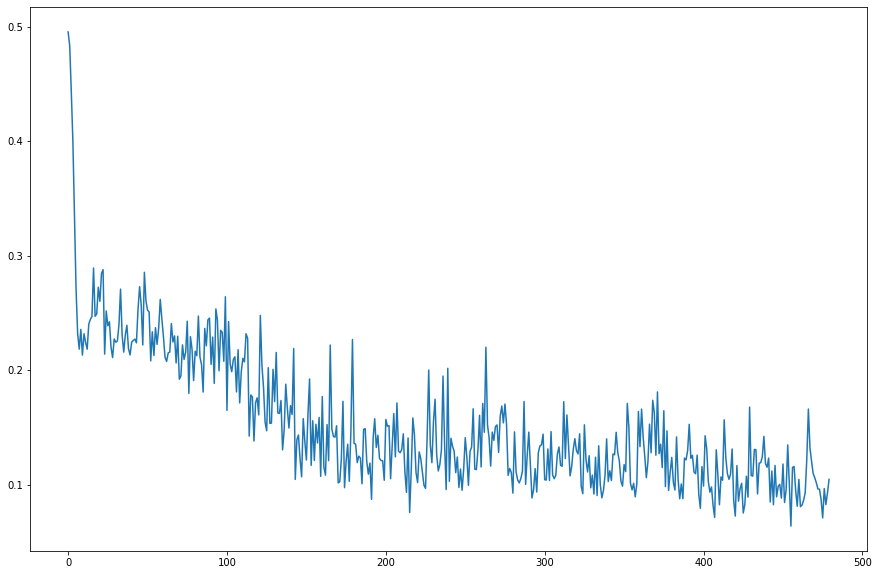

In [209]:
plt.figure(figsize=(15,10))
ax = plt.plot([i.detach().item() for i in mlosses])
plt.show()


torch.Size([3, 640, 800])


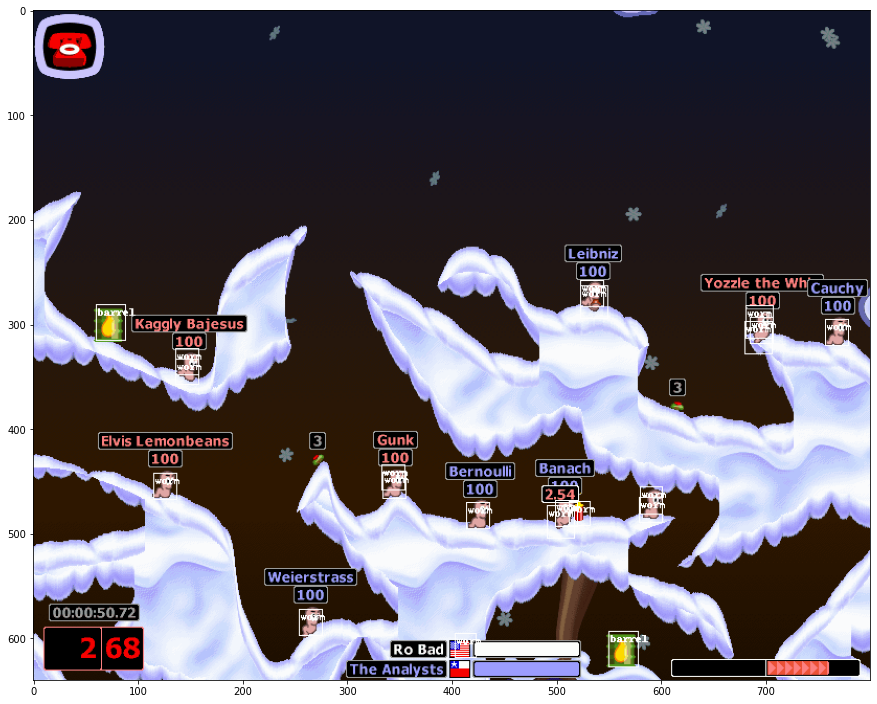

['bg', 'worm', 'mine', 'barrel', 'dynamite']

In [272]:
with torch.no_grad():
  transform = Compose([ToTensor()])
  img = transform(Image.open("/Users/lair/fun/waai/labelling/source/1616_0_21530.png").convert('RGB'))
#   img = img[:,50:,:]
  print(img.shape)
  model.eval()
  y = model(img.unsqueeze(0))[0]
#   print(y)

topk  = y['scores'].topk(21)
plt.figure(figsize=(15,15))
bb = draw_bounding_boxes(
  (img*255).to(torch.uint8), boxes=y['boxes'][topk.indices], labels=[dataset.CLASSES[i] for i in y['labels'][topk.indices]])
plt.imshow(bb.permute(1,2,0))
plt.show()
dataset.CLASSES

In [7]:
models.detection.fasterrcnn_resnet50_fpn()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/lair/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [39]:
models.mobilenet_v2()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen